# Segmentation

In [57]:
from PIL import Image
import numpy as np
from queue import PriorityQueue
from skimage.exposure import equalize_hist
from skimage.filters import gaussian, sobel, prewitt, roberts
from skimage.segmentation import find_boundaries
# import rasterio
import seaborn as sns
from tqdm import tqdm
from skimage.feature import peak_local_max
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
def show_image(image, title='', cmap='gray'):
    plt.figure(figsize=(18,12))
    plt.imshow(image, cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontsize=20)
    plt.show()

In [59]:
crops = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/crops.tif'))

band_01 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_01.tif'))
band_02 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_02.tif'))
band_03 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_03.tif'))
band_04 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_04.tif'))
band_05 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_05.tif'))
band_06 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_06.tif'))
band_07 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_07.tif'))
band_08 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_08.tif'))
band_8A = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_8A.tif'))
band_09 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_09.tif'))
band_10 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_10.tif'))
band_11 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_11.tif'))
band_12 = np.array(Image.open('/Users/vasilii/Dropbox/minnesota_3/band_12.tif'))

In [60]:
band_01 = equalize_hist(band_01)
band_02 = equalize_hist(band_02)
band_03 = equalize_hist(band_03)
band_04 = equalize_hist(band_04)
band_05 = equalize_hist(band_05)
band_06 = equalize_hist(band_06)
band_07 = equalize_hist(band_07)
band_08 = equalize_hist(band_08)
band_8A = equalize_hist(band_8A)
band_09 = equalize_hist(band_09)
band_10 = equalize_hist(band_10)
band_11 = equalize_hist(band_11)
band_12 = equalize_hist(band_12)

In [61]:
patch = 200
crops = crops[:patch,:patch]
band_01 = band_01[:patch,:patch]
band_02 = band_02[:patch,:patch]
band_03 = band_03[:patch,:patch]
band_04 = band_04[:patch,:patch]
band_05 = band_05[:patch,:patch]
band_06 = band_06[:patch,:patch]
band_07 = band_07[:patch,:patch]
band_08 = band_08[:patch,:patch]
band_8A = band_8A[:patch,:patch]
band_09 = band_09[:patch,:patch]
band_10 = band_10[:patch,:patch]
band_11 = band_11[:patch,:patch]
band_12 = band_12[:patch,:patch]

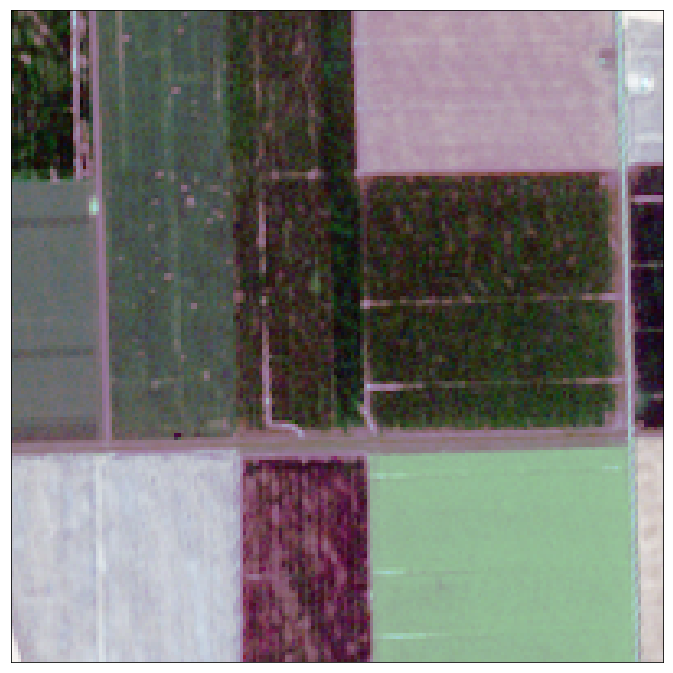

In [62]:
show_image(np.dstack([band_04, band_03, band_02]))

## Smooting

In [186]:
sigma = 3
bands = np.array([gaussian(band_01, sigma), gaussian(band_02, sigma), gaussian(band_03, sigma),
                  gaussian(band_04, sigma), gaussian(band_05, sigma), gaussian(band_06, sigma), 
                  gaussian(band_07, sigma), gaussian(band_08, sigma), gaussian(band_8A, sigma),
                  gaussian(band_09, sigma), gaussian(band_11, sigma), gaussian(band_12, sigma)])

## Generating Edge Image from Multispectral Image

In [99]:
edge_map = []
for band in bands:
    edge_map.append(sobel(band))
H = np.mean(edge_map, axis=0)

In [65]:
def extend(input_image, radius):
    extended_image = np.zeros((input_image.shape[0]+2*radius, input_image.shape[1]+2*radius),
                              dtype=input_image.dtype)
    extended_image[radius:-radius,radius:-radius] = input_image

    extended_image[:radius,:radius] = np.flipud(np.fliplr(input_image[:radius,:radius]))
    extended_image[-radius:,-radius:] = np.flipud(np.fliplr(input_image[-radius:,-radius:]))
    extended_image[:radius,-radius:] = np.flipud(np.fliplr(input_image[:radius,-radius:]))
    extended_image[-radius:,:radius] = np.flipud(np.fliplr(input_image[-radius:,:radius]))

    extended_image[:radius,radius:-radius] = np.flipud(input_image[:radius,:])
    extended_image[-radius:,radius:-radius] = np.flipud(input_image[-radius:,:])
    extended_image[radius:-radius, :radius] = np.fliplr(input_image[:,:radius])
    extended_image[radius:-radius, -radius:] = np.fliplr(input_image[:,-radius:])
    
    return extended_image

In [177]:
r = 15
SH = []

for band in tqdm(bands):
    sh = np.zeros_like(band)
    band = extend(band, r)

    for i in range(sh.shape[0]):
        for j in range(sh.shape[1]):
            window = band[i:i+2*r+2,j:j+2*r+1].flatten()
            window_sum = np.sum(window)
            p = window / window_sum
            sh[i,j] = np.sum(p * np.log1p(p)) / np.log(r**2+1)
    
    SH.append(sh)

100%|██████████| 12/12 [00:13<00:00,  1.16s/it]


In [178]:
SH = np.array(SH)
H = np.sum((SH / np.sum(SH, axis=0)) * SH, axis=0)

## Determining Seed Points

In [179]:
minimums = peak_local_max(-H)

r = 1
thr = 10
H_extended = extend(H, r)

diff = H.max() - H.min()
converged = False

while not converged:
    prev = len(minimums)
    print(prev)
    for minimum in minimums:
        window = H_extended[minimum[0]:minimum[0]+2*r+1, minimum[1]:minimum[1]+2*r+1]
        window = window.flatten()
        tor = np.abs(window - window[3*r+1]) / diff
        if np.sort(tor)[1] < thr:
            converged = False
            min_neig = np.sort(window)[1]
            window = window.reshape((2*r+1,2*r+1))
            window[np.where(window==min_neig)] = window[r,r]
            window[r,r] = min_neig
            H_extended[minimum[0]:minimum[0]+2*r+1, minimum[1]:minimum[1]+2*r+1] = window
            
    minimums = peak_local_max(-H_extended[r:-r,r:-r])
    
    if prev - len(minimums) == 0:
        converged = True

12


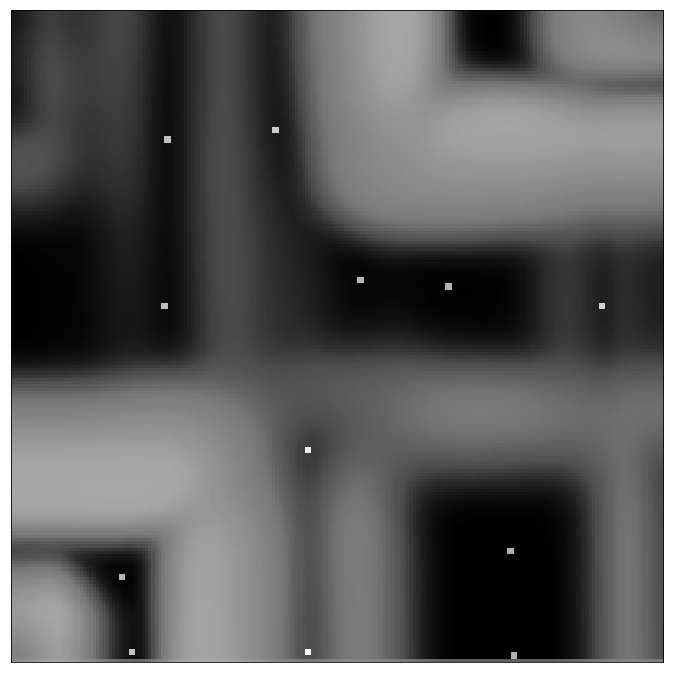

In [180]:
minimums_map = np.zeros_like(H)
for minimum in minimums:
    minimums_map[minimum[0]-1:minimum[0]+1,minimum[1]-1:minimum[1]+1] = 1
show_image(equalize_hist(H) + minimums_map)

## The Modified Seed Region Growing

In [181]:
segmented = np.zeros_like(H)
for i, minimum in enumerate(minimums):
    segmented[minimum[0], minimum[1]] = i+1
    
S_I = segmented.shape[0] * segmented.shape[1]

In [182]:
queue = PriorityQueue()

In [183]:
for minimum in minimums:
    region_num = segmented[minimum[0], minimum[1]]
    region = np.where(segmented==region_num)
    I_r = np.mean(bands[:,region[0],region[1]], axis=1)
    G_r = np.mean(H[region])
    neibors = [(minimum[0]-1, minimum[1]-1), (minimum[0]-1, minimum[1]),
                (minimum[0]-1, minimum[1]+1), (minimum[0], minimum[1]-1), 
                (minimum[0], minimum[1]+1), (minimum[0]+1, minimum[1]-1),
                (minimum[0]+1, minimum[1]), (minimum[0]+1, minimum[1]+1)]
    for neibor in neibors:
        if segmented[neibor] == 0:
            I = bands[:,neibor[0],neibor[1]]
            G = H[neibor[0], neibor[1]]
            phi = (np.dot(I,I_r)/np.linalg.norm(I)**2) * np.abs(G-G_r)
            queue.put((phi, neibor))

In [184]:
while not queue.empty():
    current_pixel = queue.get()[1]
    neibors = [(current_pixel[0]-1, current_pixel[1]-1), (current_pixel[0]-1, current_pixel[1]),
                (current_pixel[0]-1, current_pixel[1]+1), (current_pixel[0], current_pixel[1]-1), 
                (current_pixel[0], current_pixel[1]+1), (current_pixel[0]+1, current_pixel[1]-1),
                (current_pixel[0]+1, current_pixel[1]), (current_pixel[0]+1, current_pixel[1]+1)]
    neibors = [neibor for neibor in neibors if neibor[0]>=0 and neibor[0]<patch and neibor[1]>=0 and neibor[1]<patch]
    labels = np.array([segmented[neibor] for neibor in neibors])
    labels = set(labels[np.nonzero(labels)])

    segmented[current_pixel] = labels.pop()
        
    region = np.where(segmented==segmented[current_pixel])
    I_r = np.mean(bands[:,region[0],region[1]], axis=1)
    G_r = np.mean(H[region])
    in_queue = [pixel[1] for pixel in queue.queue]
    for neibor in neibors:
        if segmented[neibor] == 0 and neibor not in in_queue:
            I = bands[:,neibor[0],neibor[1]]
            G = H[neibor[0], neibor[1]]
            phi = (np.dot(I,I_r)/np.linalg.norm(I)**2) * np.abs(G-G_r)
            queue.put((phi, neibor))
    print(str(round((len(segmented.nonzero()[0])/S_I)*100, 2))+'%', end='\r')

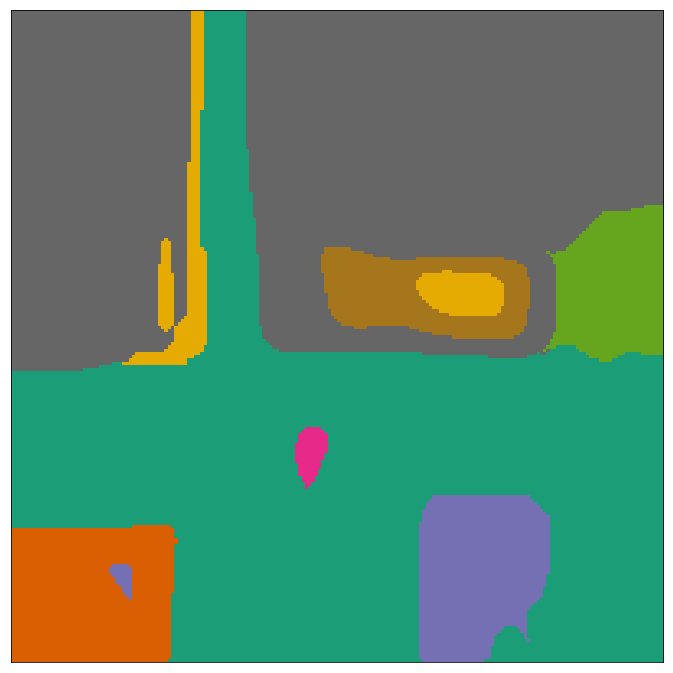

In [185]:
show_image(segmented, cmap='Dark2')

## Evaluation of Segmentation Results

In [138]:
S_j = []
for j in range(int(segmented.max())):
    S_j.append(len(np.where(segmented==j+1)[0]))
p_i = np.array(S_j) / S_I
H_l = - np.sum(p_i * np.log(p_i))

In [139]:
H_r = []
pan = np.round(np.sum(bands, axis=0), 2)
for j in range(int(segmented.max())):
    r = pan[np.where(segmented==j+1)]
    S_j = len(r)
    p_i = np.array([len(np.where(r==i)[0])/S_j for i in set(r)])
    H_v = -np.sum(p_i*np.log(p_i))
    H_r.append(S_j*H_v/S_I)
H_r = np.sum(H_r)

In [140]:
E = H_l + H_r
print(H_l)
print(H_r)
print(E)

1.4917118903748712
4.899125142865045
6.390837033239916


In [124]:
from math import *
def evalfunc2(segmented, original):
    '''
    evaluation function for the NxM input segmented image:
    F(I) = 1/(1000*(N*M)) * sqrt(R) * sum(e_i^2/sqrt(S_i)),
    where S_i - region area [pix], e_i^2 - quadratic error of the i-th segmented region
    '''
    I = segmented
    S_I = I.shape[0] * I.shape[1]
    S_j = []
    e_j = []
    R = int(I.max())
    
    for j in range(R):
        S_j.append(len(np.where(I==j+1)[0]))
        e_j.append(np.linalg.norm(original[np.where(I==j+1)] - I[np.where(I==j+1)]))
        
    e_j = np.array(e_j)
    S_j = np.array(S_j)
    F = 1/(1000*S_I) * sqrt(R) * np.sum(e_j**2 / np.sqrt(S_j))
    return F

In [125]:
def evalfuncQ(segmented, original):
    '''
    evaluation function for the NxM input segmented image:
    Q(I) = 1/(1000*(N*M)) * sqrt(R) * sum(e_i^2/1+log(S_i) + (R(S_i)/sqrt(S_i))^2),
    where S_i - region area [pix], e_i^2 - quadratic error of the i-th segmented region
    '''
    I = segmented
    S_I = I.shape[0] * I.shape[1]
    S_j = []
    e_j = []
    R = int(I.max())
    for j in range(R):
        S_j.append(len(np.where(I==j+1)[0]))
        e_j.append(np.linalg.norm(original[np.where(I==j+1)] - I[np.where(I==j+1)]))
    e_j = np.array(e_j)
    S_j = np.array(S_j)
    R_j = []
    for j in range(R):
        R_j.append( sum(S_j==S_j[j]) )
    R_j = np.array(R_j)
    Q = 1/(1000*S_I) * sqrt(R) * np.sum(e_j**2 / (1+np.log(S_j)) + (R_j / S_j)**2)
    return Q

In [141]:
Q = evalfuncQ(segmented,np.sum(bands,axis=0))
print('Evaluation Q-function value for MSRG segmentaton: '+str(Q))

Evaluation Q-function value for MSRG segmentaton: 0.0019617149467559907


In [142]:
F = evalfunc2(segmented, np.sum(bands,axis=0))
print('Evaluation F-function value for MSRG segmentaton: '+str(F))

Evaluation F-function value for MSRG segmentaton: 0.0002941352348938853


## Compare to Cluster-based Segmentation

In [159]:
from sklearn.cluster import k_means

In [187]:
features = np.dstack([bands[i,...].flatten() for i in range(12)])[0]

In [212]:
segmented_c = k_means(features, 17)

In [213]:
segmented_c = segmented_c[1].reshape((200,200))

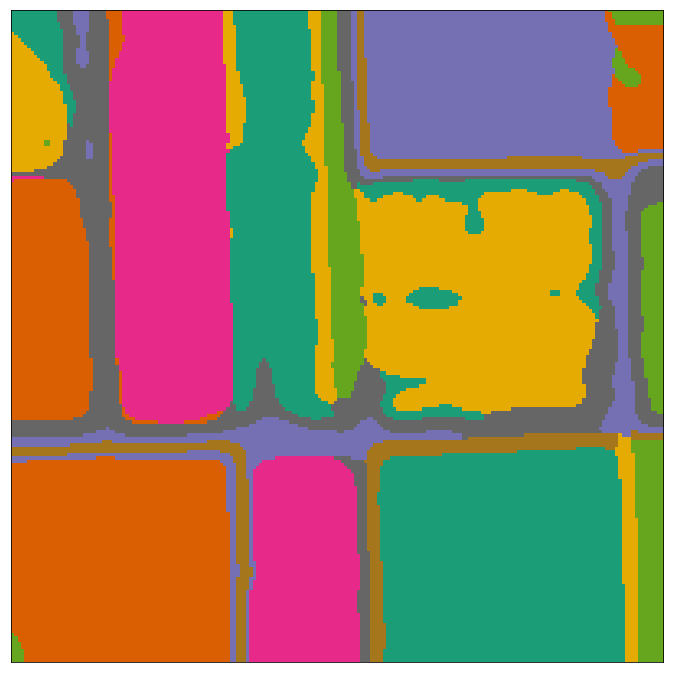

In [214]:
show_image(segmented_c, cmap='Dark2')

In [215]:
S_j = []
for j in range(int(segmented_c.max())):
    S_j.append(len(np.where(segmented_c==j+1)[0]))
p_i = np.array(S_j) / S_I
H_l = - np.sum(p_i * np.log(p_i))

In [216]:
H_r = []
pan = np.round(np.sum(bands, axis=0), 2)
for j in range(int(segmented_c.max())):
    r = pan[np.where(segmented_c==j+1)]
    S_j = len(r)
    p_i = np.array([len(np.where(r==i)[0])/S_j for i in set(r)])
    H_v = -np.sum(p_i*np.log(p_i))
    H_r.append(S_j*H_v/S_I)
H_r = np.sum(H_r)

In [217]:
E = H_l + H_r
print(H_l)
print(H_r)
print(E)

2.32836110676796
3.732775352361033
6.061136459128993


In [218]:
Q = evalfuncQ(segmented_c, np.sum(bands,axis=0))
print('Evaluation Q-function value for k-means segmentaton: '+str(Q))

Evaluation Q-function value for k-means segmentaton: 0.008938496670139372


In [219]:
F = evalfunc2(segmented_c, np.sum(bands,axis=0))
print('Evaluation F-function value for k-means segmentaton: '+str(F))

Evaluation F-function value for k-means segmentaton: 0.0017970053727981187


## Compare to Simple Linear Iterative Clustering (SLIC)

In [36]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

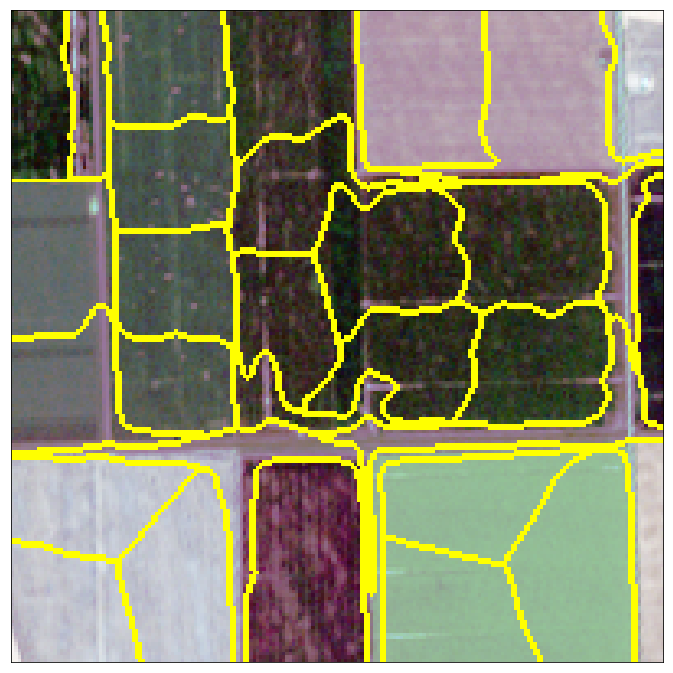

In [37]:
original = np.dstack([band_04, band_03, band_02])
segmented_slic = slic(original,n_segments=37,sigma=3)
show_image( mark_boundaries(original,segmented_slic) )

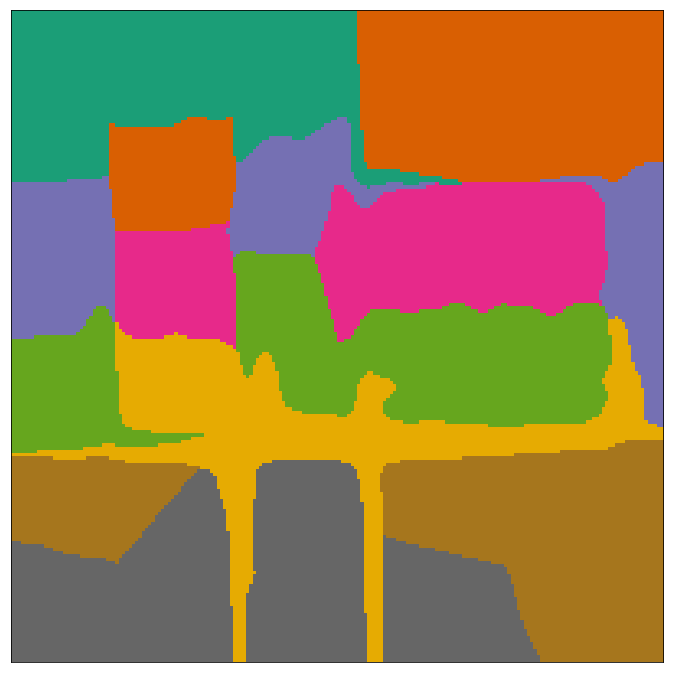

In [38]:
show_image(segmented_slic,cmap='Dark2')

In [39]:
S_I = segmented_slic.shape[0] * segmented_slic.shape[1]
S_j = []
for j in range(int(segmented_slic.max())):
    S_j.append(len(np.where(segmented_slic==j+1)[0]))
p_i = np.array(S_j) / S_I
H_l = - np.sum(p_i * np.log(p_i))

In [40]:
H_r = []
pan = np.round(np.sum(bands[[3,2,1]], axis=0), 2)
for j in range(int(segmented_slic.max())):
    r = pan[np.where(segmented_slic==j+1)]
    S_j = len(r)
    p_i = np.array([len(np.where(r==i)[0])/S_j for i in set(r)])
    H_v = -np.sum(p_i*np.log(p_i))
    H_r.append(S_j*H_v/S_I)
H_r = np.sum(H_r)

In [41]:
E = H_l + H_r
print(H_l)
print(H_r)
print(E)

3.2859605124654037
3.1527270975439863
6.43868761000939


In [284]:
Q = evalfuncQ(segmented, np.sum(bands[[3,2,1]],axis=0))
print('Evaluation Q-function value for slic-algorithm segmentaton: '+str(Q))

Evaluation Q-function value for slic-algorithm segmentaton: 0.3231486483576623


In [229]:
F = evalfunc2(segmented, np.sum(bands[[3,2,1]],axis=0))
print('Evaluation function value for slic-algorithm segmentaton: '+str(F))

Evaluation function value for slic-algorithm segmentaton: 0.06545071708411682


## Active contours

In [1]:
from skimage.segmentation import active_contour

In [5]:
band_02 = np.array(Image.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_02.tif'))
band_03 = np.array(Image.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_03.tif'))
band_04 = np.array(Image.open('/home/ruslan/Documents/Study/Skoltech/Image_Processing/Project/image_data/band_04.tif'))

In [6]:
band_02 = equalize_hist(band_02)
band_03 = equalize_hist(band_03)
band_04 = equalize_hist(band_04)

In [8]:
original = np.dstack([band_04, band_03, band_02])

In [26]:
s = np.linspace(0, 2*np.pi, 400)
x = 450 + 120*np.cos(s)
y = 400 + 120*np.sin(s)
init = np.array([x, y]).T

In [30]:
snake = active_contour(gaussian(band_02, 10), init, bc='fixed',
                       alpha=0.1, beta=1.0, w_line=-5, w_edge=0, gamma=0.1)

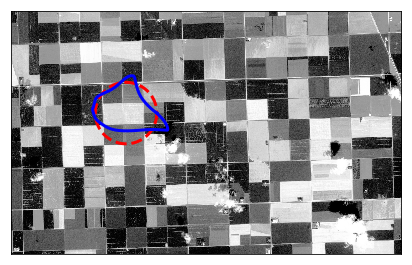

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(band_02, cmap=plt.cm.gray)
ax.plot(init[:, 0], init[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, band_02.shape[1], band_02.shape[0], 0])
plt.show()

## Color-based segmentation

In [42]:
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, binary_opening
from skimage.exposure import rescale_intensity, equalize_hist

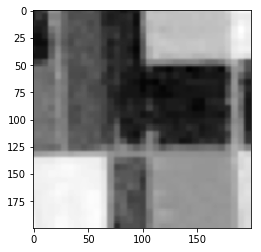

In [43]:
original = gaussian(band_01,sigma=1)
plt.imshow(original,plt.cm.gray)

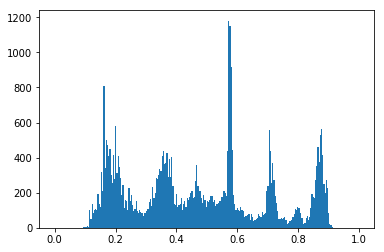

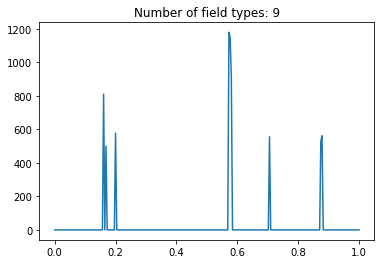

In [46]:
hist = plt.hist(original.flatten(),256, range=(0,1))
plt.show()
h = hist[0]
color = np.linspace(0,1,len(h))
hist_th = 500 # minimum nuber of pixels to build a segment
h[h<hist_th] = 0
plt.plot(color,h)
plt.title('Number of field types: '+str(len(h[h!=0])))

In [47]:
color_of_fields = color[h!=0]
band_one_color = np.zeros([original.shape[0],original.shape[1],len(color_of_fields)])

In [48]:
color_of_fields

array([0.16078431, 0.16862745, 0.2       , 0.57254902, 0.57647059,
       0.58039216, 0.70588235, 0.8745098 , 0.87843137])

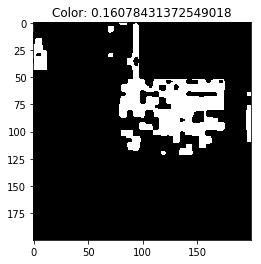

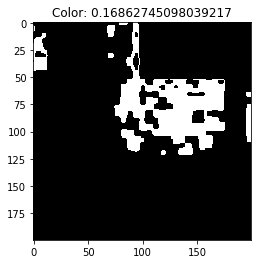

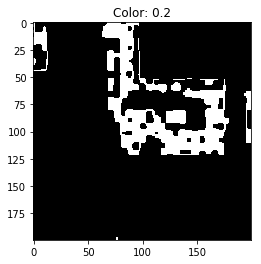

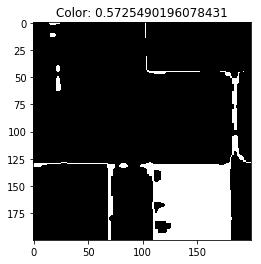

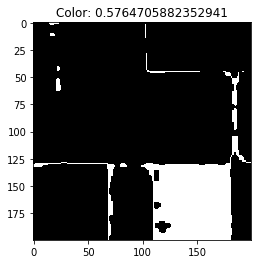

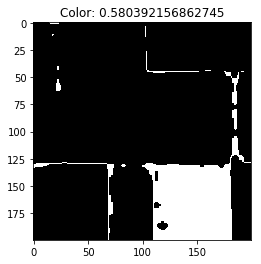

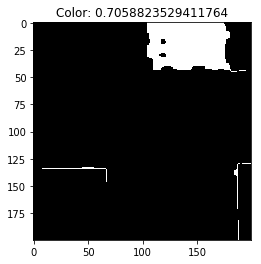

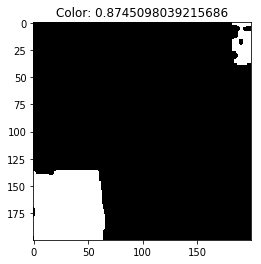

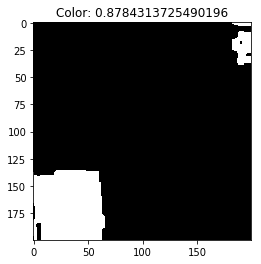

In [49]:
band_sum = np.zeros_like(original)
color_range = 0.03
for c in range(len(color_of_fields)):
    # band with particular color value
    band_one_color[...,c] = np.logical_and(original>=color_of_fields[c]-color_range,
                                           original<=color_of_fields[c]+color_range)
    # band with all chosen colors
    band_sum = np.logical_or(band_sum,band_one_color[...,c])
    plt.imshow(band_one_color[...,c],plt.cm.gray)
    plt.title('Color: '+str(color_of_fields[c]))
    plt.show()

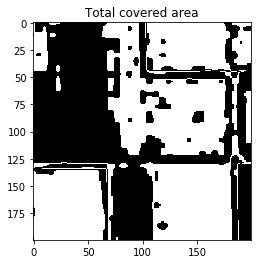

In [50]:
plt.imshow(band_sum,plt.cm.gray)
plt.title('Total covered area')
plt.show()
# balck region denotes here another type of field`

In [51]:
# Morphology for each color band
def morphband(band,Noe,Nod):
    tmp = band
    for e in range(Noe):
        eroded = binary_erosion(tmp)
        tmp = eroded

    for d in range(Nod):
        dilated = binary_dilation(eroded)
        eroded = dilated
    if Nod!=0:
        result = dilated
    else:
        result = eroded
    return result

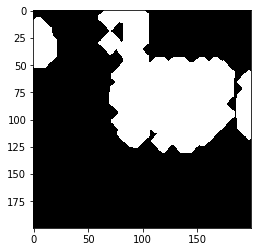

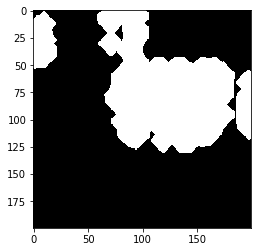

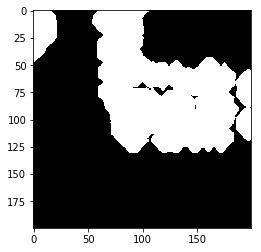

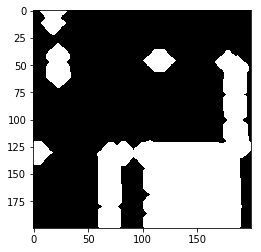

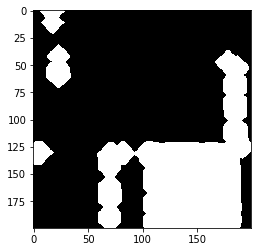

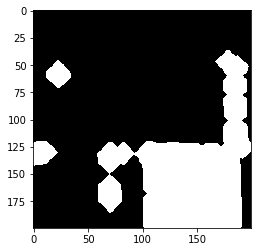

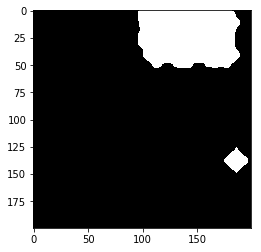

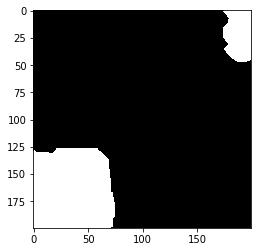

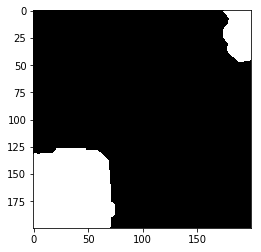

In [52]:
band_mp = np.zeros_like(band_one_color)
for c in range(len(color_of_fields)):
    band_mp[...,c] = morphband(band_one_color[...,c],Noe=1,Nod=10)
    plt.imshow(band_mp[...,c],plt.cm.gray)
    plt.show()

In [53]:
segmented_color = np.zeros_like(original)
for c in range(len(color_of_fields)):
    segmented_color[band_mp[...,c]==1] = color_of_fields[c]

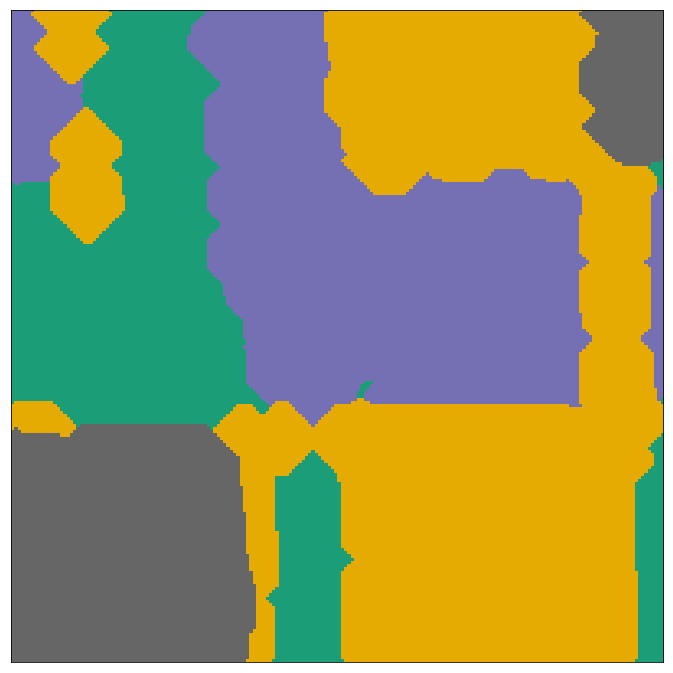

In [54]:
segmented_color = np.round( rescale_intensity(segmented_color,out_range=(0,3)), 0 )
show_image(segmented_color, cmap='Dark2')

Evaluation of results for color-based segmentation

In [55]:
S_I = segmented_color.shape[0] * segmented_color.shape[1]
S_j = []
for j in range(3):
    S_j.append(len(np.where(segmented_color==j+1)[0]))
p_i = np.array(S_j) / S_I
H_l = - np.sum(p_i * np.log(p_i))

In [56]:
H_r = []
pan = np.round(original, 2)
for j in range(2):
    r = pan[np.where(segmented_color==j+1)]
    S_j = len(r)
    p_i = np.array([len(np.where(r==i)[0])/S_j for i in set(r)])
    H_v = -np.sum(p_i*np.log(p_i))
    H_r.append(S_j*H_v/S_I)
H_r = np.sum(H_r)

In [57]:
E = H_l + H_r
print(H_l)
print(H_r)
print(E)

1.0083926935167529
2.153390551096932
3.1617832446136847


In [58]:
Q = evalfuncQ(segmented_color, original)
print('Evaluation Q-function value for color-based segmentaton: '+str(Q))

Evaluation Q-function value for color-based segmentaton: 0.00029149485271393017


In [59]:
F = evalfunc2(segmented_color, original)
print('Evaluation function value for color-based segmentaton: '+str(F))

Evaluation function value for color-based segmentaton: 3.0340324200748462e-05
